# Zeldovich Approximation 2D

In [1]:
# !pip install git+https://github.com/pynbody/pynbody.git

In [2]:
import numpy as np
import pynbody
import matplotlib.pylab as plt

In [3]:
def whitenoise(N):    
    return np.random.normal(0,1,size=(N,N))

def sanitize(ar):
    """Remove infinities and NaNs from an array"""
    ar[ar!=ar]=0
    ar[ar==np.inf]=0

In [4]:
def apply_powerlaw_power_spectrum(f, n=-1.0,min_freq=2.0,max_freq=200.0):
    f_fourier = np.fft.fft2(f)
    freqs = np.fft.fftfreq(f.shape[0])
    freqs_2 = np.sqrt(freqs[:,np.newaxis]**2+freqs[np.newaxis,:]**2)
    f_fourier[freqs_2<min_freq/f.shape[0]]=0
    f_fourier[freqs_2>max_freq/f.shape[0]]=0
    freqs_2**=n
    sanitize(freqs_2)
    f_fourier*=freqs_2
    return np.fft.ifft2(f_fourier).real

In [5]:
def get_potential_gradients(den_real):
    """Starting from a density field in 2D, get the potential gradients i.e.
    returns the two components of grad (grad^-2 den_real)"""
    den = np.fft.fft2(den_real)

    freqs = np.fft.fftfreq(den.shape[0])

    del_sq_operator = -(freqs[:,np.newaxis]**2+freqs[np.newaxis,:]**2)

    grad_x_operator = -1.j*np.fft.fftfreq(den.shape[0])[:,np.newaxis]
    grad_y_operator = -1.j*np.fft.fftfreq(den.shape[0])[np.newaxis,:]

    phi = den/del_sq_operator
    sanitize(phi)

    grad_phi_x = grad_x_operator*phi
    grad_phi_y = grad_y_operator*phi

    grad_phi_x_real = np.fft.ifft2(grad_phi_x).real
    grad_phi_y_real = np.fft.ifft2(grad_phi_y).real

    return grad_phi_x_real, grad_phi_y_real

In [6]:
def get_evolved_particle_positions(den,Delta_t=0.025):
    """Generate a grid of particles, one for each cell of the density field,
    then displace those particles along gradient of potential implied by
    the density field."""
    N = len(den)
    x,y = np.mgrid[0.:N,0.:N]
    grad_x, grad_y = get_potential_gradients(den)
    x+=Delta_t*grad_x
    y+=Delta_t*grad_y
    x[x>N]-=N
    y[y>N]-=N
    x[x<0]+=N
    y[y<0]+=N
    return x.flatten(),y.flatten()

In [7]:
def get_final_density(input_linear_field, output_resolution=None, time=0.025):
    """Starting from a linear field, generate the equivalent non-linear field under the
    Zeldovich approximation at the specified time. If the output resolution is not
    specified, it is chosen to match in the input resolution. Output is both returned
    as a numpy array and displayed in a matplotlib window."""
    assert input_linear_field.shape[0]==input_linear_field.shape[1]
    N=len(input_linear_field)
    if not output_resolution:
        output_resolution = N
    x,y = get_evolved_particle_positions(input_linear_field,time)
    f = pynbody.new(len(x))
    f['x']=x-N/2
    f['y']=y-N/2
    f['mass']=1.0
    f['mass'].units="kg"
    f['x'].units="cm"
    return x, y, f, pynbody.plot.sph.image(f,width=N,resolution=output_resolution,units="kg cm^-2")

In [8]:
def create_linear_field(resolution=1024):
    return apply_powerlaw_power_spectrum(whitenoise(resolution))

/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  import sys
/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Text(0.5,1,'Zeldovich demo')

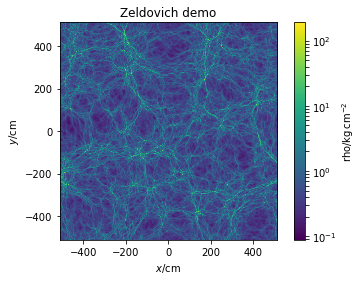

In [18]:
linear_field = create_linear_field()
x, y, f, plot = get_final_density(linear_field, time=0.025)
plt.title("Zeldovich demo")

/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  import sys
/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Text(0.5,1,'Zeldovich demo')

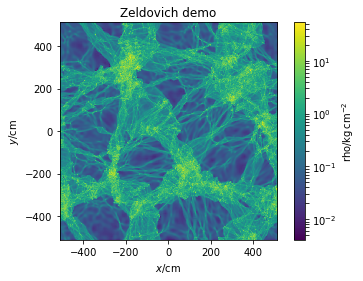

In [26]:
linear_field = create_linear_field()
x, y, f, plot = get_final_density(linear_field, time=0.1)
plt.title("Zeldovich demo")

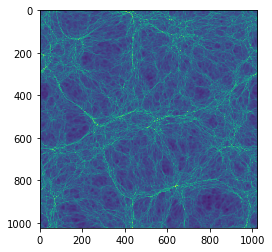

In [11]:
plt.imshow(np.log10(plot).T)

In [12]:
y.max()

1023.999350301844

In [13]:
#==============================================================
def densityCIC(x,y):   #  0 <  x, y, z < nGr*refFactor in 1D 
    #x = (x-x_l)*Nx/(x_h - x_l)
    #y = (y-y_l)*Ny/(y_h - y_l) 
    
    Np = np.size(x)
    macro = np.zeros([nGr, nGr])

    for particle in range(Np):
        i = int(x[particle]) 
        j = int(y[particle]) 

        dx = 1
        dy = 1
        
        a1 = np.around(x[particle], decimals = 4) - i*dx
        b1 = np.around(y[particle], decimals = 4) - j*dy
        
        a2 = dx - a1
        b2 = dy - b1
        
        wx1 = a1/dx
        wx2 = a2/dx
        wy1 = b1/dy
        wy2 = b2/dy        
        
        macro[i, j] += (wx1 * wy1)
        macro[np.mod(i+1,nGr), j] += (wx2 * wy1)
        macro[i, np.mod(j+1,nGr)] += (wx1 * wy2)
        macro[np.mod(i+1,nGr), np.mod(j+1,nGr)] += (wx2 * wy2 )
    return macro

#==============================================================

In [14]:
L = 1024.
nGr = 1024

x0_1d = x*nGr/L 
x1_1d = y*nGr/L 

macro = densityCIC(x0_1d, x1_1d)
macro_max = macro.max()

/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


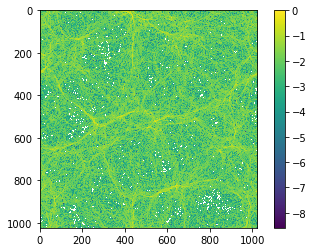

In [15]:
den = macro/macro_max
plt.figure(3222)
plt.imshow(np.log10(den))
plt.colorbar()
plt.show()

In [33]:
den.max()

1.0

In [17]:
den.min()

0.0

## Exercises

In [ ]:
1. Is this periodic? If not, how to enforce it?
2. Make a redshift evolution plot of ZA
3. Think of ways to speed-up the calculation at each step. For example, current CIC density estimates is awfully slow - 
2. Write an equivalent in 3D ZA approximation
